# Geothermal and Machine Learning Sandbox

# Skeleton of an Variational Bayes Artificial Neural Network (BNN) in PyTorch applied to Nevada PFA Geothermal Resources Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math

import pickle

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from scipy.stats import kurtosis

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load packages to create dataset
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset
from torch import Tensor

from torch.utils.data import WeightedRandomSampler

# from torchvision import models
from torchsummary import summary

import datetime
import time

from pathlib import Path
import sys

import h5py

from tqdm.notebook import trange, tqdm

%matplotlib inline

# Training Setup

In [2]:
# ALPHA = 4.19
ALPHA = 2.35

In [3]:
BATCH_SIZE = 64

In [4]:
TRAIN_EPOCHS = 1000

## BEGIN data preprocessing

## load preprocessed data

In [5]:
path = '../../datasets/'

filename = 'PFA_features&labels_march2021_tc2_imbalanced_SmoothLSS_FSS_df.h5'

hf5File = path+filename

In [6]:
f = h5py.File(hf5File, 'r')

def keys(f):
    return [key for key in f.keys()]

key_list = keys(f)
print(key_list)

f.close()

['X', 'XyInfo', 'dfInfo', 'dfn', 'nullIndexes', 'scaler', 'y']


In [7]:
dfXAll = pd.read_hdf(hf5File, key='X')
dfyAll = pd.read_hdf(hf5File, key='y')
XyInfo = pd.read_hdf(hf5File, key='XyInfo')

In [8]:
print( dfXAll.shape, dfyAll.shape, XyInfo.shape)

(725, 20) (725,) (725, 17)


In [9]:
dfXAll.head()

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,GravityDensity,MagneticDensity,GeochemistryTemperature2,Silica_Distance,TufaOrTravertine_Distance,DEM-30m,FavorableStructuralSettings_Distance
1629211,0.605907,1.214984,3.191540,1.120474,-0.784042,0.956721,-0.383781,-1.553196,3.963975,-2.485171,0.451266,-1.352377,0.856456,-1.447685,0.042378,7.965358,-1.153277,-1.748728,0.071722,-1.439888
792748,2.753820,0.973401,0.219568,2.368457,0.743874,2.838552,-0.631091,-1.014735,-1.162640,1.180387,1.218827,0.250527,-1.224496,-1.678404,0.500513,-0.185826,0.993788,1.746996,-0.003075,0.524243
1427233,-0.532809,-0.586230,-0.402900,-0.584992,1.248917,1.627900,-0.435304,-1.246016,-0.087931,0.565757,-0.099213,-2.182920,0.426947,-1.332326,1.416784,-0.185826,0.055923,1.526730,-0.137194,1.095007
630421,0.627393,1.615954,-0.183165,1.500129,-1.064303,-1.286707,-0.662004,-0.813587,-1.262306,0.897017,0.459076,0.142340,-0.693443,0.974860,0.844115,-0.185826,1.719070,1.030348,0.948657,-1.130844
741007,-0.108018,-0.384650,-0.362674,-0.394128,-0.965216,-0.928128,-0.971141,-0.811781,-1.198261,0.909340,0.206954,-0.170018,-0.528820,-0.178733,1.416784,-0.185826,1.529526,1.298969,0.732003,-0.038541


In [10]:
dfyAll.head()

1629211    1
792748     0
1427233    0
630421     0
741007     0
Name: labels, dtype: int64

In [11]:
XyInfo.head()

,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id
1629211,942.0,1435.0,R943C1436,645077.690182,4.494214e+06,notNull,12,1,1,14,84.074090,14,84.074090,4,10574.081138,315,0
792748,458.0,1324.0,R459C1325,617327.690182,4.373214e+06,notNull,2,12,12,76,109719.824992,47,28269.390720,48,224.802810,24,0
1427233,825.0,1633.0,R826C1634,694577.690182,4.464964e+06,notNull,1,12,12,14,57577.584385,25,49848.864916,31,83.994037,0,0
630421,364.0,1429.0,R365C1430,643577.690182,4.349714e+06,notNull,2,12,12,13,88734.532066,55,38087.135264,41,173.133020,37,0
741007,428.0,1423.0,R429C1424,642077.690182,4.365714e+06,notNull,2,12,12,13,104234.526475,47,37025.554552,33,218.270209,0,0


In [12]:
columns=dfXAll.columns

### balance the dataset?

In [13]:
# balance = None
# balance = 'truncate'
balance = 'weighted'

### balance dataset method 1: by truncation

In [14]:
if balance == 'truncate':
    dfyAll_neg = dfyAll[dfyAll==0]
    dfyAll_pos = dfyAll[dfyAll==1]
    dfXAll_neg = dfXAll.loc[dfyAll_neg.index]
    dfXAll_pos = dfXAll.loc[dfyAll_pos.index]
    
    # find out which set is smaller
    imin = np.argmin([len(dfyAll_neg), len(dfyAll_pos)])
    
    if imin==0:
        dfyAll_pos = dfyAll_pos.sample(n=len(dfyAll_neg))
        dfXAll_pos = dfXAll_pos.loc[dfyAll_pos.index]
    elif imin==1:
        dfyAll_neg = dfyAll_neg.sample(n=len(dfyAll_pos))
        dfXAll_neg = dfXAll_neg.loc[dfyAll_neg.index]

    dfXAll = pd.concat([dfXAll_neg, dfXAll_pos])
    dfyAll = pd.concat([dfyAll_neg, dfyAll_pos])
    XyInfo = XyInfo.loc[dfXAll.index]

### balance dataset method 2: design weighted sampler for dataloaders

In [15]:
if balance == 'weighted':
    class_counts = dfyAll.value_counts()
    class_weights = class_counts/len(dfyAll)

    print(class_counts.values,  class_weights.values)

[415 310] [0.57241379 0.42758621]


### break into features and labels

In [16]:
XAll = dfXAll
yAll = dfyAll

In [17]:
XAll.shape

(725, 20)

In [18]:
yAll.shape

(725,)

In [19]:
XAll.columns

Index(['Local-StructuralSetting', 'Local-QuaternaryFaultRecency',
       'Local-QuaternaryFaultSlipDilation', 'Local-QuaternaryFaultSlipRate',
       'QuaternaryFaultTraces', 'HorizGravityGradient2',
       'HorizMagneticGradient2', 'GeodeticStrainRate', 'QuaternarySlipRate',
       'FaultRecency', 'FaultSlipDilationTendency2', 'Earthquakes', 'Heatflow',
       'GravityDensity', 'MagneticDensity', 'GeochemistryTemperature2',
       'Silica_Distance', 'TufaOrTravertine_Distance', 'DEM-30m',
       'FavorableStructuralSettings_Distance'],
      dtype='object')

In [20]:
yAll.name

'labels'

### train/test split

In [21]:
X_trainAll, X_testAll, y_trainAll, y_testAll = train_test_split(
    XAll, yAll, test_size=0.33, random_state=42)
    # XAll, yAll, test_size=0.33)

In [22]:
print (X_trainAll.shape, y_trainAll.shape, X_testAll.shape, y_testAll.shape)

(485, 20) (485,) (240, 20) (240,)


In [23]:
X_trainAll.head()

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,GravityDensity,MagneticDensity,GeochemistryTemperature2,Silica_Distance,TufaOrTravertine_Distance,DEM-30m,FavorableStructuralSettings_Distance
851760,1.219532,1.907248,0.150295,2.039372,-0.211921,1.557584,0.296321,-1.218099,0.455146,0.218541,0.639279,-1.200670,-0.469886,-1.447685,-0.644825,-0.185826,1.339493,-1.021991,0.035613,-1.214275
918627,-0.276916,-0.203856,-0.021599,-0.403835,-1.064303,-0.292717,-0.569263,-0.811781,-0.922382,-1.454516,-0.400033,-0.787486,0.507925,-0.986248,0.156912,-0.185826,-0.351455,-1.018601,0.198104,-0.658516
1528718,-0.092083,-0.287456,-0.283656,-0.019209,-0.309676,2.304730,-0.198299,-1.537737,-0.428710,0.947958,0.481170,-0.467806,-0.467885,-1.678404,0.271446,-0.185826,-0.452455,-0.201201,-0.397695,0.010648
626965,0.564056,1.495610,-0.195161,1.386182,-1.064303,-1.304623,-0.651700,-0.813587,-1.268894,0.949120,0.460385,0.118718,-0.701636,1.090220,0.729581,-0.185826,1.724593,1.008396,0.982187,-1.091732
134427,-0.398323,-0.395663,-0.276137,-0.384507,0.095486,2.098599,-1.032969,-0.052316,0.787964,0.168520,-0.360607,0.504901,-1.420290,-1.678404,1.645851,-0.185826,1.916649,-0.381975,-0.895485,-0.793871


In [24]:
y_trainAll.head()

851760     0
918627     0
1528718    0
626965     0
134427     0
Name: labels, dtype: int64

In [25]:
print(y_trainAll.shape, y_trainAll.sum())

(485,) 275


In [26]:
columns = X_trainAll.columns.to_list()
columns

['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'GravityDensity',
 'MagneticDensity',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
 'DEM-30m',
 'FavorableStructuralSettings_Distance']

## select feature set

In [27]:
featureSets = [

# MASTER SET 1
################################# 0
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],

]

print (len(featureSets))

1


In [28]:
# featureSets

In [29]:
feature_set = 0

columns = featureSets[feature_set]

columns

['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m']

## END data preprocessing

## fix input types and dimensions

In [30]:
X_train = X_trainAll[columns].copy()
X_test = X_testAll[columns].copy()

y_train = y_trainAll.copy()
y_test = y_testAll.copy()

In [31]:
nFeatures = X_train.shape[1]
nFeatures

10

In [32]:
print (X_train.shape, y_train.shape)

(485, 10) (485,)


### balance dataset method 2: using weighted samplers in the dataloaders

In [33]:
if balance == 'weighted':

    # training dataloader sampler
    sample_weights = [1-class_weights[i] for i in y_train.to_numpy()]
    sampler = WeightedRandomSampler(weights=sample_weights, 
                                    num_samples=len(y_train), replacement=True)

    # testing dataloader sampler
    sample_weights_test = [1-class_weights[i] for i in y_test.to_numpy()]
    sampler_test = WeightedRandomSampler(weights=sample_weights_test, 
                                         num_samples=len(y_test), replacement=True)

# Build model

### use GPU

In [34]:
# setting device on GPU if available, else CPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')
print('Using device:', DEVICE)
print()

#Additional Info when using cuda
if DEVICE.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 2070
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## custom dataset class to put random numbers in certain columns each call

In [35]:
# class CustomDataset(Dataset):
#     def __init__(self, X, y, randomList=[]):
#         self.X = X.clone() # without clone this seems to retain changes in original array
#         self.y = y.clone()
#         self.randomList = randomList
        
#     def __len__(self):
#         return len(self.X)
    
#     def __getitem__(self, idx):
#         if self.randomList:
#             self.X[idx,self.randomList] = torch.rand(len(self.randomList))*0
#         return self.X[idx], self.y[idx]

In [36]:
# # test new custom datasets

# features = Tensor(X_train.to_numpy())
# labels = Tensor(y_train.to_numpy()).long()

# dataset = CustomDataset(features, labels, randomList=[9,10,11,12,13,14])
# # dataset = CustomDataset(features, labels)
# print('Number of samples in the data: ', len(dataset))
# print(dataset[2])
# print(dataset[0:5])

In [37]:
# feature columns to continually randomize

# randomList = [9,10,11,12,13,14]

## create datasets and batch loaders

In [38]:
###################################################################
# Create train dataset from several tensors with matching first dimension
features = Tensor(X_train.to_numpy())
labels = Tensor(y_train.to_numpy()).long()

train_dataset = TensorDataset( features, labels )
# train_dataset = CustomDataset( features, labels, randomList ) # randomize certain columns

# Create a data loader from the dataset
if balance == None or balance == 'truncate':
    # Type of sampling and batch size are specified at this step
    train_loader = DataLoader(train_dataset, shuffle=True, 
                              batch_size=BATCH_SIZE, drop_last=True)

if balance == 'weighted':
    # weighted sampler to balance training data
    train_loader = DataLoader(train_dataset, sampler=sampler, 
                              batch_size=BATCH_SIZE, drop_last=True)

###################################################################
# Create test dataset from several tensors with matching first dimension
features = Tensor(X_test.to_numpy())
labels = Tensor(y_test.to_numpy()).long()

test_dataset = TensorDataset( features, labels )
# test_dataset = CustomDataset( features, labels, randomList ) # randomize certain columns

# Create a data loader from the dataset
if balance == None or balance == 'truncate':
    test_loader = DataLoader(test_dataset, shuffle=False, 
                             batch_size=BATCH_SIZE, drop_last=True)

if balance == 'weighted':
    # need this weighted sampler to balance testing data too, 
    #      otherwise learning curves are odd
    # a weighted test_loader is a good substitute for the required weighting 
    #      of the test accuracy in imbalanced cases ... 
    #      since accuracies are means over epochs statistics are incorrect without it
    #
    # test_loader = DataLoader(test_dataset, shuffle=False, 
    #                          batch_size=BATCH_SIZE, drop_last=False)
    # test_loader = DataLoader(test_dataset, sampler=sampler_test, 
                             # batch_size=BATCH_SIZE, drop_last=False)
    test_loader = DataLoader(test_dataset, sampler=sampler_test, 
                             batch_size=BATCH_SIZE, drop_last=True)    

## vanilla pytorch bayes by backprop

### global variables

In [39]:
TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)

NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

# CLASSES = 2

# SAMPLES = 3
# TEST_SAMPLES = 10

In [40]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
#         epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        epsilon = self.normal.sample().to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def entropy(self, input):
#         entropy = 0.5 * torch.log(2 * math.pi * math.e * self.sigma**2)
        entropy = -self.normal.log_prob(input).exp() * self.normal.log_prob(input)
        return entropy.sum()

    def log_prob(self, input):
        return (- math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [41]:
from scipy.stats import gennorm

class GenNormal(object):
    def __init__(self, beta, scale):
        super().__init__()
        self.beta = beta.cpu().numpy()
        self.scale = scale.cpu().numpy()
        self.gennormal = gennorm(self.beta, loc=0.0, scale=self.scale)
    
    @property
    def sigma(self):
        return self.gennormal.std()
    
    def sample(self):
        rv = self.gennormal.rvs(self.scale.shape[0])
        rv = torch.FloatTensor(rv).to(DEVICE)
        return rv
    
    def entropy(self, input):
        x = input.cpu().detach().numpy()
        entropy = -self.gennormal.pdf(x) * self.gennormal.logpdf(x)
        entropy = torch.FloatTensor(entropy)
        return entropy.sum()

    def log_prob(self, input):
        x = input.cpu().detach().numpy()
#         x = input
        logprob = self.gennormal.logpdf(x)
        logprob = torch.FloatTensor(logprob)
        return logprob.sum()

In [42]:
class Normal(object):
    def __init__(self, scale):
        super().__init__()
        self.scale = scale
        self.normal = torch.distributions.Normal(loc=0.0, scale=self.scale)
        
    def sample(self):
        sample = self.normal.sample().to(DEVICE)
        return sample
    
    def entropy(self):
        entropy = self.normal.entropy()
        return entropy

    def log_prob(self, input):
        prob = self.normal.log_prob(input)
        return prob.sum()

## prior starting parameters

In [43]:
BETAw = torch.FloatTensor([10]).to(DEVICE)
BETAb = torch.FloatTensor([10]).to(DEVICE)

SCALEw = torch.FloatTensor([0.3]).to(DEVICE)
SCALEb = torch.FloatTensor([0.3]).to(DEVICE)

## view the prior

In [44]:
prior = Normal(SCALEw)
# prior = GenNormal(BETAw, SCALEw)

In [45]:
prior_x = torch.FloatTensor(np.linspace(-10,10,1000))
# print(x)
# x = (np.linspace(-5,5,1000))
prior_pdf = np.array([])
for xsample in prior_x:
#     xsample = xsample.cpu()
    p = np.exp(prior.log_prob(xsample).cpu().numpy())
    prior_pdf = np.append(prior_pdf, p)    

In [46]:
prior_samples=np.array([])
for i in range(10000):
    sample = prior.sample()
    if abs(sample) < 10:
        prior_samples = np.append(prior_samples,sample.cpu().detach().numpy())
    
kurs = kurtosis(prior_samples, fisher=False)

print (kurs)

2.915225073526393


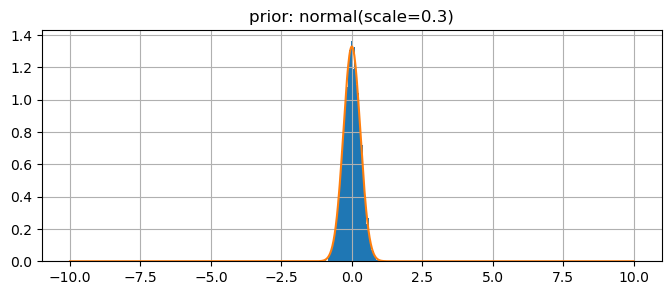

In [47]:
plt.rc('figure', figsize=(8, 3))

plt.hist(prior_samples, 50, density=True, label='prior');
plt.plot(prior_x, prior_pdf);
plt.grid(True)

# plt.xlim(-0.5,0.5)

plt.title('prior: normal(scale='+str(SCALEw.cpu().numpy()[0])+')');
# plt.title('prior: gennormal(beta=10, scale=0.3');
# plt.savefig('figures/prior-gennormal.png')

# plt.savefig('figures/prior-normal('+str(SCALEw.cpu().numpy()[0])+')'+'.png')


In [48]:
from sklearn import mixture

In [49]:
X = prior_samples.reshape(-1, 1)

In [50]:
# gmm = mixture.GaussianMixture(n_components = 2, max_iter=100000, covariance_type='diag').fit(X)
gmm = mixture.BayesianGaussianMixture(n_components = 2, max_iter=100000).fit(X)

In [51]:
print (gmm.means_.squeeze())
print ("")
print (np.sqrt(gmm.covariances_).squeeze())

[-0.12808932  0.14057298]

[0.26758178 0.26404733]


## Bayesian modules

In [52]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features

        # Weight parameters
        self.weight_mu  = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        
        # Bias parameters
        self.bias_mu  = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        
        # Prior distributions
#         self.weight_prior = GenNormal(BETAw, SCALEw)
#         self.bias_prior   = GenNormal(BETAb, SCALEb)

        self.weight_prior = Normal(SCALEw)
        self.bias_prior   = Normal(SCALEb)

        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)

In [53]:
class BayesianNetwork(nn.Module):
    def __init__(self, nFeatures, nHidden, nLabels, complexityWeight):
        super().__init__()
        self.nFeatures = nFeatures
        self.nHidden   = nHidden
        self.nLabels   = nLabels
        
        self.complexityWeight = complexityWeight
        
        self.l1 = BayesianLinear(self.nFeatures, self.nHidden)
        self.l2 = BayesianLinear(self.nHidden, self.nHidden)
        self.l3 = BayesianLinear(self.nHidden, self.nLabels)
        
        self.LeakyRelu  = nn.LeakyReLU(0.1)
        self.BatchNorm  = nn.BatchNorm1d(self.nHidden)
        self.dropout    = nn.Dropout(p=0.3)
        self.LogSoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x, sample=False):
        x = x.view(-1, self.nFeatures)
        
        x = self.l1(x, sample)
#         x = self.BatchNorm(x)
        x = self.LeakyRelu(x)

        x = self.l2(x, sample)
        x = self.LeakyRelu(x)

        x = self.l3(x, sample)
        x = self.LogSoftmax(x)
        
        return x
    
    def mfvi_forward(self, inputs, stat=None, q=None, sample_nbr=10):
        """
        Perform mean-field variational inference for the variational estimator model:
            Performs sample_nbr forward passes with uncertainty on the weights, 
            returning its mean and standard deviation
        """
        # logits from all samples - are these logsoftmax called logits?
        logits = torch.stack([self(inputs, sample=True) for _ in range(sample_nbr)])
        # convert logits to probability
        probability = torch.exp(logits)
        
        if   stat == 'mean':
            value = torch.mean(probability, dim=0)
        elif stat == 'stddev':
            value = torch.std(probability, dim=0)
        elif stat == 'mode':
            value, _ = torch.mode(probability, dim=0)
        elif stat == 'quantile':
            value = torch.quantile(probability, q, dim=0)
        else:
            value = torch.tensor([0.0])            
        return value

    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l3.log_variational_posterior
    
    def get_weights(self, param):
        if param == 'samples':
            return self.l1.weight.sample(), self.l2.weight.sample(), self.l3.weight.sample()
        elif param == 'sigmas':
            return self.l1.weight.sigma, self.l2.weight.sigma, self.l3.weight.sigma
        elif param == 'means':
            return self.l1.weight.mu, self.l2.weight.mu, self.l3.weight.mu
    
    def get_biases(self, param):
        if param == 'samples':
            return self.l1.bias.sample(), self.l2.bias.sample(), self.l3.bias.sample()
        elif param == 'sigmas':
            return self.l1.bias.sigma, self.l2.bias.sigma, self.l3.bias.sigma
        elif param == 'means':
            return self.l1.bias.mu, self.l2.bias.mu, self.l3.bias.mu

    def sample_elbo(self, input, target, samples=3):
        outputs = torch.zeros(samples, BATCH_SIZE, self.nLabels).to(DEVICE)
        log_priors = torch.zeros(samples).to(DEVICE)
        log_variational_posteriors = torch.zeros(samples).to(DEVICE)
        
        for i in range(samples):
            outputs[i] = self(input, sample=True) # this is same as "forward"
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()

        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()

        negative_log_likelihood = F.nll_loss(outputs.mean(0), target, reduction='mean')

        loss = self.complexityWeight*(log_variational_posterior - log_prior) + negative_log_likelihood

        return loss, log_prior, log_variational_posterior, negative_log_likelihood

In [54]:
def train(net, optimizer, epoch):
    
    ###########
    net.train()
    total = 0
    total_loss = 0.0
    total_log_prior = 0.0
    total_log_variational_posterior = 0.0
    total_negative_log_likelihood = 0.0
    for batch_idx, (features, labels) in enumerate(train_loader):
        features, labels = features.to(DEVICE), labels.to(DEVICE)
        net.zero_grad()
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(features, labels)
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        total_loss += loss.cpu().detach().numpy()
        total_log_prior += log_prior.cpu().detach().numpy()
        total_log_variational_posterior += log_variational_posterior.cpu().detach().numpy()
        total_negative_log_likelihood += negative_log_likelihood.cpu().detach().numpy()
        
    epoch_loss = total_loss / total
    epoch_log_prior = total_log_prior / total
    epoch_log_variational_posterior = total_log_variational_posterior / total
    epoch_negative_log_likelihood = total_negative_log_likelihood / total

    ###########
    net.eval()
    # average train accuracy per epoch ... since this is an average they should be weighted
    correct = 0
    total = 0
    with torch.no_grad():
        for data in train_loader:
            features, labels = data
            outputs = net(features.to(DEVICE), sample=True)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(DEVICE)).sum().item()

    epoch_train_acc = 100 * correct / total
    
    # average test accuracy per epoch ... since this is an average they should be weighted
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            features, labels = data
            outputs = net(features.to(DEVICE), sample=True)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(DEVICE)).sum().item()

    epoch_test_acc = 100 * correct / total

    return epoch_loss, epoch_train_acc, epoch_test_acc, \
            epoch_log_prior, epoch_log_variational_posterior, epoch_negative_log_likelihood

In [55]:
def evaluate(net, epoch):
    
    ###########
    net.eval()
    total = 0
    total_loss = 0.0
    total_log_prior = 0.0
    total_log_variational_posterior = 0.0
    total_negative_log_likelihood = 0.0
    for batch_idx, (features, labels) in enumerate(train_loader):
        features, labels = features.to(DEVICE), labels.to(DEVICE)
#         net.zero_grad()
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(features, labels)
#         loss.backward()
#         optimizer.step()
        total += labels.size(0)
        total_loss += loss.cpu().detach().numpy()
        total_log_prior += log_prior.cpu().detach().numpy()
        total_log_variational_posterior += log_variational_posterior.cpu().detach().numpy()
        total_negative_log_likelihood += negative_log_likelihood.cpu().detach().numpy()
        
    epoch_loss = total_loss / total
    epoch_log_prior = total_log_prior / total
    epoch_log_variational_posterior = total_log_variational_posterior / total
    epoch_negative_log_likelihood = total_negative_log_likelihood / total

    ###########
    net.eval()
    # average train accuracy per epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for data in train_loader:
            features, labels = data
            outputs = net(features.to(DEVICE), sample=True)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(DEVICE)).sum().item()

    epoch_train_acc = 100 * correct / total
    
    # average test accuracy per epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            features, labels = data
            outputs = net(features.to(DEVICE), sample=True)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(DEVICE)).sum().item()

    epoch_test_acc = 100 * correct / total

    return epoch_loss, epoch_train_acc, epoch_test_acc, \
            epoch_log_prior, epoch_log_variational_posterior, epoch_negative_log_likelihood

## model instance

### settings

In [56]:
# total number of probabilistic weights + biases
nHidden = 16
nLabels = 2
nBayesianModules = nFeatures*nHidden + \
                     nHidden*nHidden + \
                     nHidden*nLabels + \
                     nHidden + nHidden + nLabels

weightScale = ALPHA

complexityWeight = weightScale/nBayesianModules

print ('complexity weight = ',complexityWeight)

complexity weight =  0.00487551867219917


In [57]:
net = BayesianNetwork(nFeatures, nHidden, nLabels, complexityWeight).to(DEVICE)

In [58]:
summary(net, features.shape, col_names=("input_size", "output_size", "num_params"), verbose=2, depth=2);

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
├─BayesianLinear: 1-1                    [-1, 10]                  [-1, 16]                  352
|    └─weight_mu
|    └─weight_rho
├─LeakyReLU: 1-2                         [-1, 16]                  [-1, 16]                  --
├─BayesianLinear: 1-3                    [-1, 16]                  [-1, 16]                  544
|    └─weight_mu
|    └─weight_rho
├─LeakyReLU: 1-4                         [-1, 16]                  [-1, 16]                  --
├─BayesianLinear: 1-5                    [-1, 16]                  [-1, 2]                   68
|    └─weight_mu
|    └─weight_rho
├─LogSoftmax: 1-6                        [-1, 2]                   [-1, 2]                   --
Total params: 964
Trainable params: 964
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01


## view starting weights and biases

In [59]:
param = 'means'
weights = np.hstack([net.get_weights(param)[0].cpu().detach().numpy().flatten(), 
                     net.get_weights(param)[1].cpu().detach().numpy().flatten(),
                     net.get_weights(param)[2].cpu().detach().numpy().flatten()])
biases  = np.hstack([net.get_biases(param)[0].cpu().detach().numpy().flatten(), 
                     net.get_biases(param)[1].cpu().detach().numpy().flatten(),
                     net.get_biases(param)[2].cpu().detach().numpy().flatten()])

print (weights.mean(), weights.std())
print (biases.mean(), biases.std())

-0.0037849487 0.11646534
-0.029149616 0.098973885


In [60]:
weights.shape

(448,)

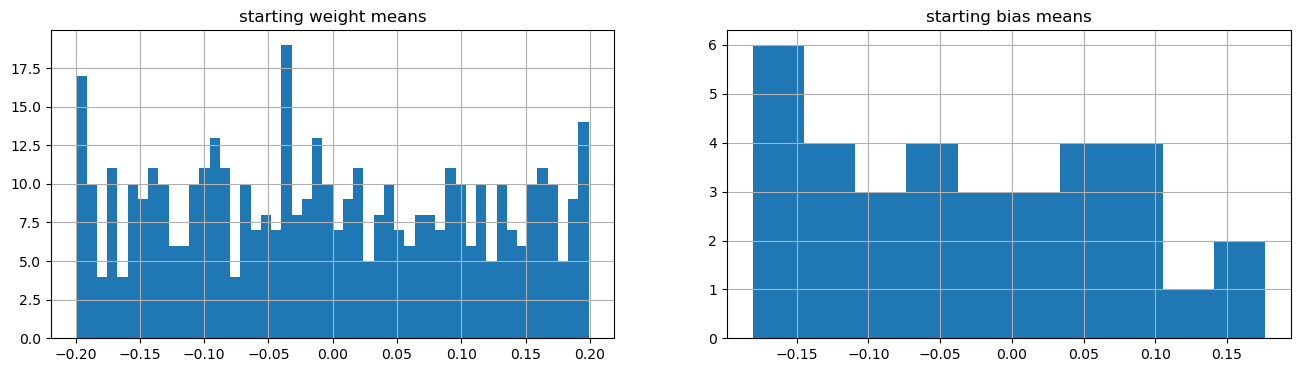

In [61]:
plt.rc('figure', figsize=(16, 4))

plt.subplot(121)
plt.hist(weights,50);
plt.grid(True)
plt.title('starting weight means')

plt.subplot(122)
plt.hist(biases,10);
plt.grid(True)
plt.title('starting bias means');

# plt.savefig('figures/starting_weights_biases.png')

In [62]:
kurw = kurtosis(weights, fisher=False)
kurb = kurtosis(biases, fisher=False)

print (kurw, kurb)

1.8395381599661857 2.0209216516293145


# train model

In [63]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [64]:
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5, verbose=True)

In [65]:
epoch_train_loss = []
epoch_train_acc = []
epoch_test_acc = []

epoch_logprior = []
epoch_logvarprior = []
epoch_negloglikelihood = []

for epoch in tqdm(range(TRAIN_EPOCHS)):
    
    eloss, etrain_acc, etest_acc, elogprior, elogvarprior, enegloglikelihood \
        = train(net, optimizer, epoch)
    
    # adjust learning rate
    # scheduler.step()
    scheduler.step(eloss)
    
    epoch_train_loss.append(eloss)
    epoch_train_acc.append(etrain_acc)
    epoch_test_acc.append(etest_acc)
    
    epoch_logprior.append(elogprior)
    epoch_logvarprior.append(elogvarprior)
    epoch_negloglikelihood.append(enegloglikelihood)            
        
train_loss = np.asarray(epoch_train_loss)
train_acc = np.asarray(epoch_train_acc)
test_acc = np.asarray(epoch_test_acc)

train_logprior = np.asarray(epoch_logprior)
train_logvarprior = np.asarray(epoch_logvarprior)
train_negloglikelihood = np.asarray(epoch_negloglikelihood)


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 00639: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00740: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00841: reducing learning rate of group 0 to 1.2500e-04.
Epoch 00942: reducing learning rate of group 0 to 6.2500e-05.


## learning curves

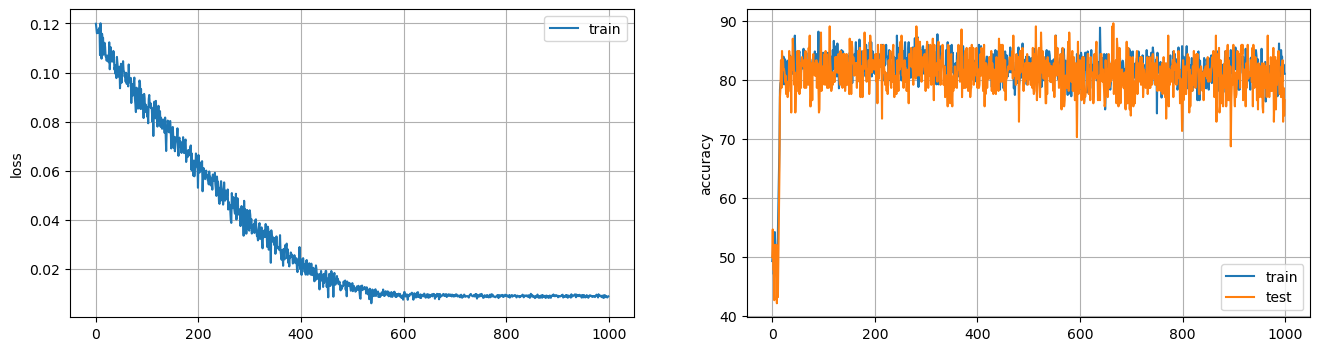

In [66]:
plt.rc('figure', figsize=(16, 4))

# plt.suptitle('learning curves: prior=norm'+str(BETAw.cpu().numpy())+
#              ', '+str(SCALEw.cpu().numpy())+'), complexity_weight='+str(weightScale))

plt.subplot(121)
plt.plot(train_loss, label='train')
# plt.plot(test_loss, label='test')
plt.ylabel('loss')
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.ylabel('accuracy')
plt.legend()
# plt.ylim([50,100])
plt.grid(True)


# plt.savefig('figures/learning_curves1_prior-0_0.1_0.5_complexityWeight-4.png')
# plt.savefig('figures/learningCurves1_priorNormal0.3_complexityWeight3_featureSet2.png')

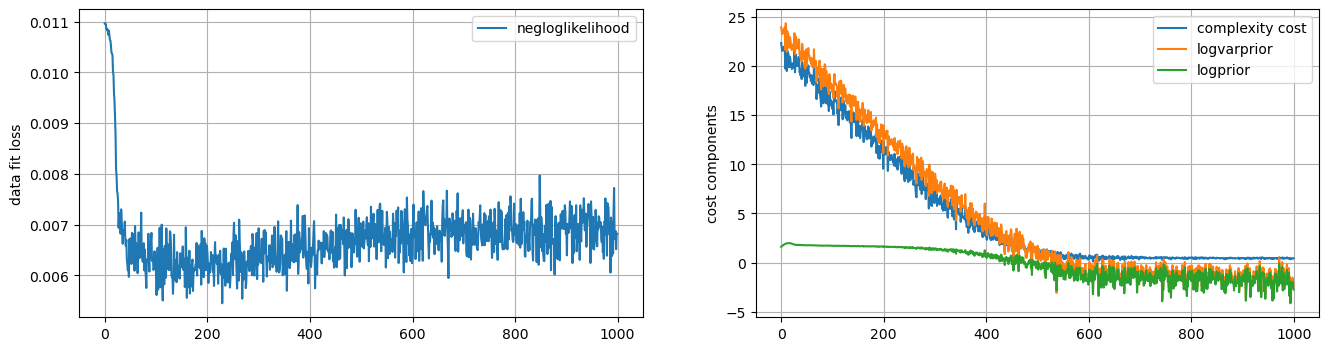

In [67]:
plt.rc('figure', figsize=(16, 4))

# plt.suptitle('learning curves: prior=norm'+str(BETAw.cpu().numpy())+
#              ', '+str(SCALEw.cpu().numpy())+'), complexity_weight='+str(weightScale))

plt.subplot(121)
plt.plot(train_negloglikelihood, label='negloglikelihood')
# plt.plot(test_loss, label='test')
plt.ylabel('data fit loss')
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.plot((train_logvarprior - train_logprior), label='complexity cost')
plt.plot(train_logvarprior, label='logvarprior')
plt.plot(train_logprior, label='logprior')
plt.ylabel('cost components')
plt.legend()
# plt.ylim([50,100])
plt.grid(True)

# plt.savefig('figures/learning_curves2_prior-0_0.1_0.5_complexityWeight-4.png')
# plt.savefig('figures/learningCurves2_priorNormal0.3_complexityWeight52_TC2.png')

# Evaluate model

## statistics

In [68]:
param = 'means'

weightsM = np.hstack([net.get_weights(param)[0].cpu().detach().numpy().flatten(), 
                     net.get_weights(param)[1].cpu().detach().numpy().flatten(),
                     net.get_weights(param)[2].cpu().detach().numpy().flatten()])
biasesM  = np.hstack([net.get_biases(param)[0].cpu().detach().numpy().flatten(), 
                     net.get_biases(param)[1].cpu().detach().numpy().flatten(),
                     net.get_biases(param)[2].cpu().detach().numpy().flatten()])

kurw = kurtosis(weightsM, fisher=False)
kurb = kurtosis(biasesM, fisher=False)

print (weightsM.mean(), weightsM.std())
print (biasesM.mean(), biasesM.std())
print (kurw, kurb)

0.0032437055 0.09800366
0.027473401 0.114612244
35.79783565941384 4.753361723443161


In [69]:
param = 'sigmas'

weightsS = np.hstack([net.get_weights(param)[0].cpu().detach().numpy().flatten(), 
                     net.get_weights(param)[1].cpu().detach().numpy().flatten(),
                     net.get_weights(param)[2].cpu().detach().numpy().flatten()])
biasesS  = np.hstack([net.get_biases(param)[0].cpu().detach().numpy().flatten(), 
                     net.get_biases(param)[1].cpu().detach().numpy().flatten(),
                     net.get_biases(param)[2].cpu().detach().numpy().flatten()])

kurw = kurtosis(weightsS, fisher=False)
kurb = kurtosis(biasesS, fisher=False)

print (weightsS.mean(), weightsS.std())
print (biasesS.mean(), biasesS.std())
print (kurw, kurb)

0.2904822 0.015591968
0.28109622 0.022895418
15.485780228433226 5.3732074854164145


In [70]:
param = 'samples'
weight_samples = np.array([])
for i in range(1000):
    sample = np.hstack([net.get_weights(param)[0].cpu().detach().numpy().flatten(), 
                net.get_weights(param)[1].cpu().detach().numpy().flatten(),
                net.get_weights(param)[2].cpu().detach().numpy().flatten()])
    weight_samples = np.append(weight_samples,sample)

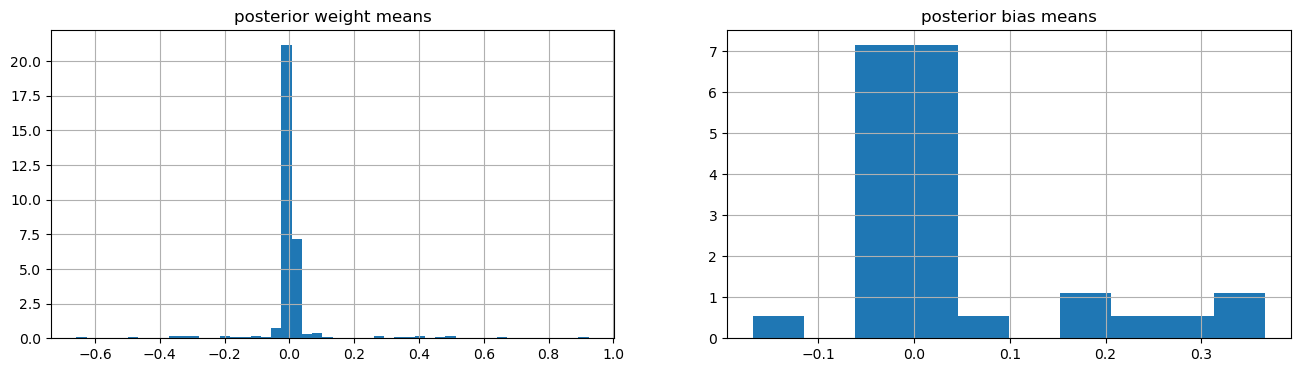

In [71]:
plt.rc('figure', figsize=(16, 4))

plt.subplot(121)
plt.hist(weightsM,50,density=True);
plt.title('posterior weight means')
plt.grid(True)

plt.subplot(122)
plt.hist(biasesM,10,density=True);
plt.title('posterior bias means')
plt.grid(True)

## fit probability model to use for prior next time

In [72]:
X = weightsM.copy().reshape(-1, 1)

### gennorm

In [73]:
params = gennorm.fit(X)

print (params)

(0.27298925694897885, -0.0037000256441347525, 5.05952113649301e-05)


In [74]:
gennorm_params = params

# gennorm_params = (0.27, 0.0002, 0.0002)

### gmm

In [75]:
# gmm = mixture.GaussianMixture(n_components = 2, max_iter=1000, covariance_type='full').fit(X)
gmm = mixture.BayesianGaussianMixture(n_components = 2, max_iter=1000).fit(X)

In [76]:
print (gmm.means_.squeeze())
print ("")
print (np.sqrt(gmm.covariances_).squeeze())

[-0.00087793  0.04245895]

[0.01433811 0.31200105]


In [77]:
x=np.linspace(-3,3,1000).reshape(-1, 1)

# gennorm fit
gennorm_pdf = gennorm.pdf(x,gennorm_params[0],loc=gennorm_params[1],scale=gennorm_params[2])

# gmm firt
logprob = gmm.score_samples(x)
gmm_pdf = np.exp(logprob)

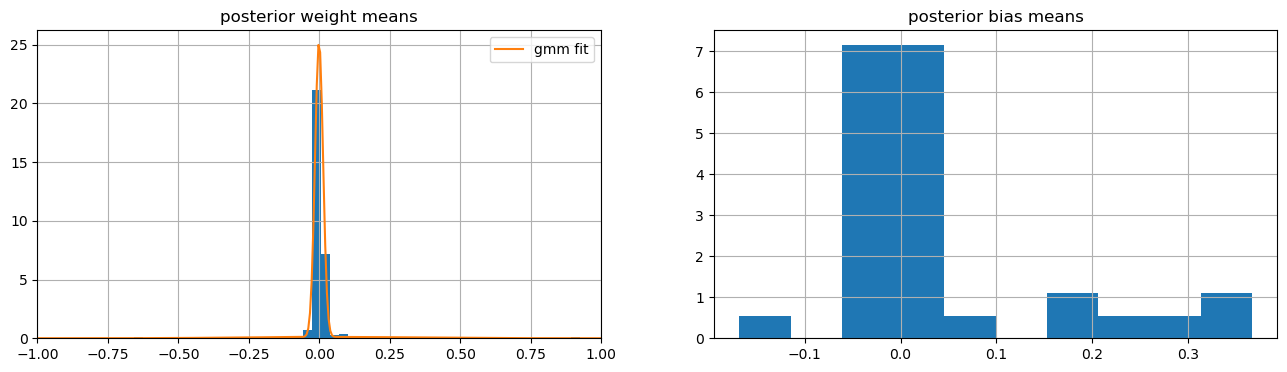

In [78]:
# x=np.linspace(-,1,1000)
# cdf = gennorm.cdf(x,params[0],loc=params[1],scale=params[2])

# plt.suptitle('posterior weight means fit gennorm('+str(params)+')');

plt.rc('figure', figsize=(16, 4))

plt.subplot(121)
plt.hist(weightsM,50, density=True);
# plt.plot(x,gennorm_pdf, label='gennorm fit')
plt.plot(x,gmm_pdf, label='gmm fit')
plt.title('posterior weight means')
plt.grid(True)
plt.legend()
# plt.xlim(-0.1,0.1)
plt.xlim(-1,1)

plt.subplot(122)
plt.hist(biasesM,10, density=True);
plt.title('posterior bias means')
plt.grid(True)

# plt.savefig('figures/posteriors_prior-0_0.1_0.5_complexityWeight-4.png')
# plt.savefig('figures/posteriors_priorNormal0.3_complexityWeight52.png')

In [79]:
final_differential_entropy = gennorm.entropy(params[0],loc=params[1],scale=params[2])

In [80]:
# initial_differential_entropy = gennorm.entropy(BETAw.cpu().numpy(),loc=0,scale=SCALEw.cpu().numpy())
initial_differential_entropy = prior.entropy().cpu().detach().numpy()[0]

In [81]:
entropy_change = initial_differential_entropy - final_differential_entropy

print (initial_differential_entropy, final_differential_entropy, entropy_change)

s0 = 'S_prior  = '+"{:.2f}".format(initial_differential_entropy)
s1 = 'S_posterior  = '+"{:.2f}".format(final_differential_entropy)
s2 = 'S_change = '+"{:.2f}".format(entropy_change)

0.2149657 -2.851764294713246 3.0667299958164564


Text(0.05, 0.95, 'Differential Entropy\nS_prior  = 0.21\nS_posterior  = -2.85\nS_change = 3.07')

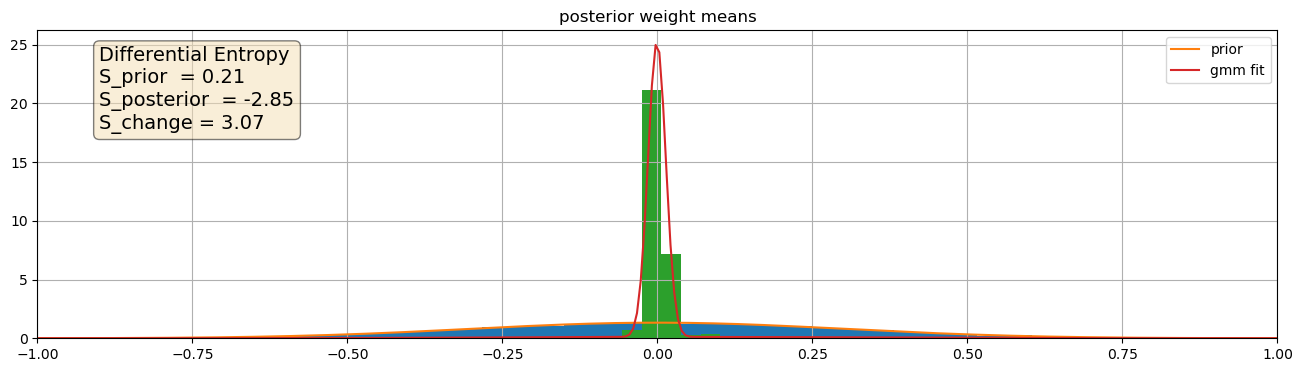

In [82]:
plt.rc('figure', figsize=(16, 4))

fig, ax = plt.subplots()

ax.hist(prior_samples, 50, density=True)
ax.plot(prior_x, prior_pdf, label='prior')
ax.hist(weightsM,50, density=True);
# ax.plot(x,gennorm_pdf, label='gennorm fit')
ax.plot(x,gmm_pdf, label='gmm fit')
plt.title('posterior weight means')
ax.grid(True)
ax.legend()
plt.xlim(-1,1)
# plt.xlim(-0.1,0.1)


textstr = '\n'.join(('Differential Entropy', s0, s1, s2))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('figures/posteriors2_priorNormal0.3_complexityWeight52.png')

### gmm

In [83]:
# gmm = mixture.GaussianMixture(n_components = 2, max_iter=1000, covariance_type='full').fit(X)
gmm = mixture.BayesianGaussianMixture(n_components = 3).fit(X)

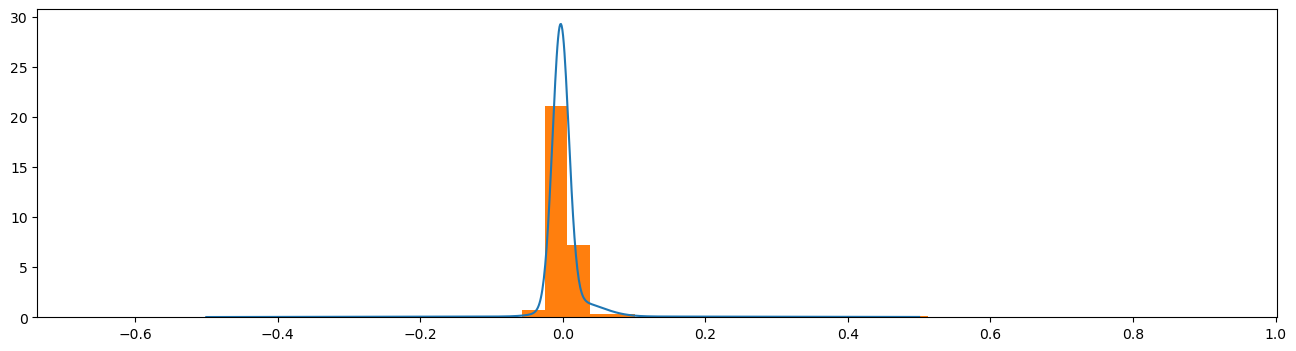

In [84]:
x=np.linspace(-0.5,0.5,1000).reshape(-1, 1)
logprob = gmm.score_samples(x)

plt.plot(x,np.exp(logprob))
plt.hist(weightsM, 50, density=True);

In [85]:
print (gmm.means_.squeeze())
print ("")
print (np.sqrt(gmm.covariances_).squeeze())

[-0.00293347  0.03986192  0.02152333]

[0.01135679 0.35733569 0.03378974]


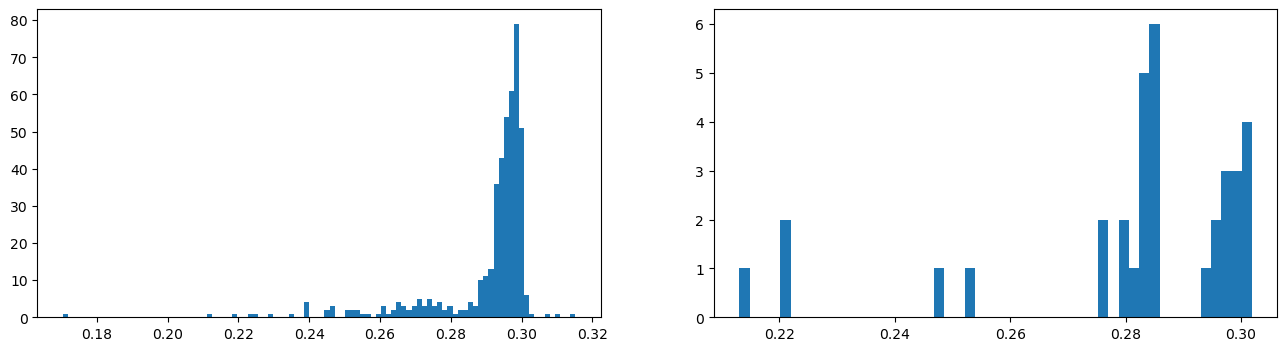

In [86]:
plt.rc('figure', figsize=(16, 4))

plt.subplot(121)
plt.hist(weightsS,100);

plt.subplot(122)
plt.hist(biasesS,50);

## look at signal/noise in weights for possible pruning

In [87]:
weightsS2N = weightsM/weightsS

/tmp/ipykernel_15016/725836840.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(311)


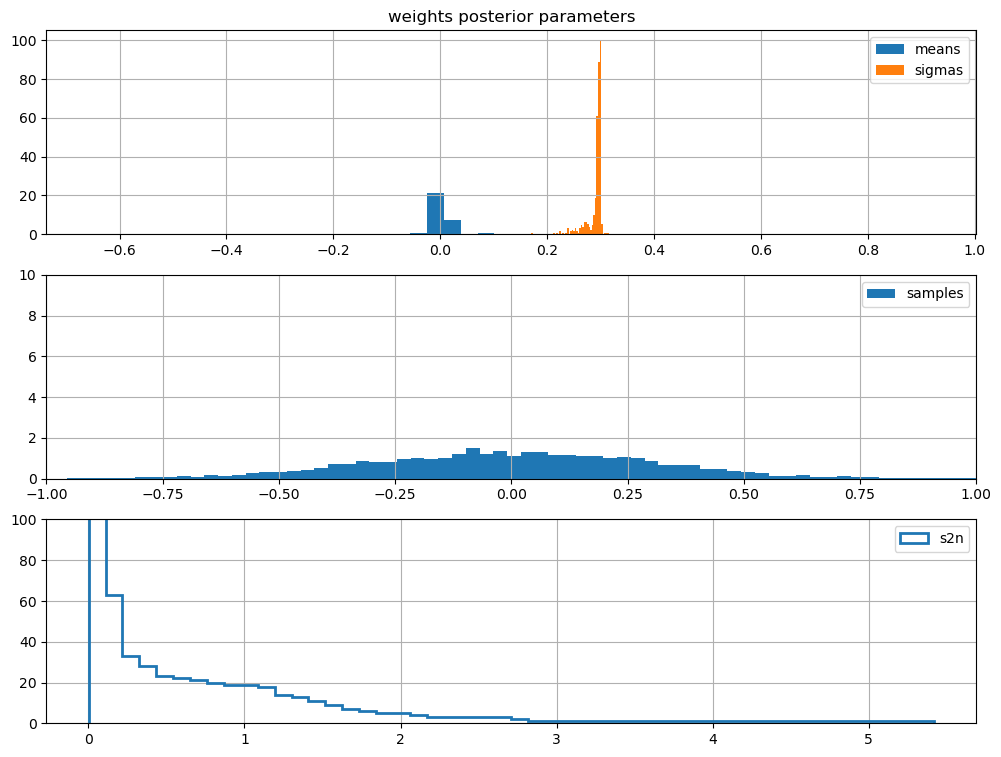

In [88]:
plt.rc('figure', figsize=(12, 9))

plt.title('weights posterior parameters')

plt.subplot(311)
plt.hist(weightsM, 50, density=True, label='means');
plt.hist(weightsS, 50, density=True, label='sigmas');
# plt.hist(np.abs(weightsS2N), 50, density=False, label='s2n', alpha=0.5);
plt.grid(True)
# plt.xlim(-0.5,3)
# plt.ylim(0,10)
plt.legend()
plt.title('weights posterior parameters')

plt.subplot(312)
plt.hist(weight_samples, 100, density=True, label='samples');
plt.grid(True)
plt.xlim(-1,1)
plt.ylim(0,10)
plt.legend()

plt.subplot(313)
# plt.hist(weightsM, 50, density=True, label='means');
# plt.hist(weightsS, 50, density=True, label='sigmas');
plt.hist(np.abs(weightsS2N), 50, density=False, histtype='step',
                           cumulative=-1, label='s2n', linewidth=2);
# plt.hist(np.abs(weightsS2N), 50, density=False, histtype='step',
#                            cumulative=True, label='s2n', linewidth=2);
# plt.hist(np.abs(weightsS2N), 50, density=True);
plt.grid(True)
# plt.xlim(-0.5,3)
plt.ylim(0,100)
plt.legend()

# plt.savefig('figures/posteriors3_priorNormal0.3_complexityWeight52.png')

## save model

In [89]:
model_filename = 'BNN_model_trial_'+str(ALPHA)+'.torch'
print (model_filename)
torch.save(net, model_filename)

BNN_model_trial_2.35.torch


## save learning curve data

In [90]:
# traintest_filename = 'bayesian_traintest_'+ \
#                     'group'+str(grp)+'_'+ \
#                     'featureSet'+str(feature_set)+'.pkl'

In [91]:
# traintest_dict = {'group': grp, 'feature_set': feature_set, 
#                   'train_loss': train_loss, 
#                   'train_acc': train_acc, 
#                   'test_acc': test_acc}

# # write python dict to a file
# output = open(traintest_filename, 'wb')
# pickle.dump(traintest_dict, output)
# output.close()

# # read python dict back from the file
# pkl_file = open(traintest_filename, 'rb')
# traintest_dict2 = pickle.load(pkl_file)
# pkl_file.close()

# print (traintest_dict)
# print (traintest_dict2)

In [92]:
xxx

NameError: name 'xxx' is not defined

# Extra Stuff

## evaluate the classifier

In [ ]:
X = X_test.to_numpy()
y = y_test.to_numpy()

# X = np.vstack((X_train.to_numpy(), X_test.to_numpy()))
# y = np.hstack((y_train.to_numpy(), y_test.to_numpy()))

In [ ]:
net.eval()

net.to(DEVICE)
features = Tensor(X).to(DEVICE)

with torch.no_grad():
    p = net.mfvi_forward(features, stat='mean', q=None, sample_nbr=1024)
    s = net.mfvi_forward(features, stat='stddev', q=None, sample_nbr=1024)
    q = net.mfvi_forward(features, stat='quantile', q=0.1, sample_nbr=1024)


In [ ]:
ypred = p[:,1].cpu()
ystd = s[:,1].cpu()
yq = q[:,1].cpu()

In [ ]:
plt.rc('figure', figsize=(12, 3))

plt.hist(ypred,50, label='mean');
plt.hist(yq, 50, alpha=0.5, label='quantile=0.1');
plt.legend()

plt.grid(True)

In [ ]:
# p_mean = torch.softmax(m.cpu().detach(), dim=1).numpy()

# confLevel= '68%';  nstddev = 1
# # confLevel= '95%';  nstddev = 2
# # confLevel= '99.7%'; nstddev = 3

# p_min = torch.softmax(torch.stack((m[:,0]+nstddev*s[:,0], m[:,1]-nstddev*s[:,1])).T, dim=1).cpu().detach().numpy()
# p_max = torch.softmax(torch.stack((m[:,0]-nstddev*s[:,0], m[:,1]+nstddev*s[:,1])).T, dim=1).cpu().detach().numpy()

# ypred = p_mean[:,1]
# # ypred = p_min[:,1]
# # ypred = p_max[:,1]


In [ ]:
def to_class(ypred,threshold):
    yclass = np.zeros(ypred.shape,dtype='int')
    yclass[ypred > threshold] = 1
    return yclass

def CrossEntropyLoss(ypred, y):
    if y == 1:
        loss = -np.log(ypred)
    else:
        loss = -np.log(1 - ypred)
    return loss

In [ ]:
threshold = 0.5

yclass = to_class(ypred, threshold)
pred_positives = np.sum(yclass)

d = y-yclass
true_positives = np.sum(y)
false_positives = np.sum(np.abs(d[d==-1]))
false_negatives = np.sum(d[d==1])

accuracy = float(pred_positives)/float(true_positives)
precision = true_positives/(true_positives + false_positives)
recall = true_positives/(true_positives + false_negatives)
print (pred_positives, true_positives, false_positives, false_negatives)
print (accuracy, precision, recall)


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

y_true = y.squeeze()
y_pred = yclass.squeeze() 
# labels = ['noise', 'event']

# print (y_true)

# # # Print f1, precision, and recall scores
# print(precision_score(y_true, y_pred, average="macro"))
# print(recall_score(y_true, y_pred , average="macro"))
# print(f1_score(y_true, y_pred , average="macro"))
print('Report for Trained Classifier')
print(classification_report(y_true, y_pred))

print('')
print('Confusion Matrix')
print('[true negative  false positive]')
print('[false negative  true positive]')
print('')
print(confusion_matrix(y_true, y_pred))
print('')

In [ ]:
print(precision_score(y_true, y_pred, average="macro"))
print(recall_score(y_true, y_pred , average="macro"))
print(f1_score(y_true, y_pred , average="macro"))
# print(classification_report(y_true, y_pred))

In [ ]:
ypred.shape

In [ ]:
# roc curve and auc
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y, ypred)

roc_auc = auc(fpr, tpr)

In [ ]:
plt.rc('figure', figsize=(6,6))

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')

# idx4 = np.where(np.abs(thresholds)>=0.4)[0][-1]
idx5 = np.where(np.abs(thresholds)>=0.5)[0][-1]
idx6 = np.where(np.abs(thresholds)>=0.6)[0][-1]
idx7 = np.where(np.abs(thresholds)>=0.7)[0][-1]
idx8 = np.where(np.abs(thresholds)>=0.8)[0][-1]
idx9 = np.where(np.abs(thresholds)<=0.9)[0][-1]

# plt.plot(fpr[idx4],tpr[idx4],'o', label='threshold=0.4')
plt.plot(fpr[idx5],tpr[idx5],'o', label='threshold=0.5')
plt.plot(fpr[idx6],tpr[idx6],'o', label='threshold=0.6')
plt.plot(fpr[idx7],tpr[idx7],'o', label='threshold=0.7')
plt.plot(fpr[idx8],tpr[idx8],'o', label='threshold=0.8')
plt.plot(fpr[idx9],tpr[idx9],'o', label='threshold=0.9')

plt.legend(loc="lower right")

plt.grid(True)

# plt.savefig('figures/roc.png')

“A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.”

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y, ypred)

In [ ]:
plt.rc('figure', figsize=(6,6))

lw = 2
plt.plot(recall, precision, color='darkorange',
         lw=lw, label='PR curve')
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision / Recall Curve')

idx5 = np.where(np.abs(thresholds)<=0.5)[0][-1]
idx6 = np.where(np.abs(thresholds)<=0.6)[0][-1]
idx7 = np.where(np.abs(thresholds)<=0.7)[0][-1]
idx8 = np.where(np.abs(thresholds)<=0.8)[0][-1]
idx9 = np.where(np.abs(thresholds)<=0.9)[0][-1]

plt.plot(recall[idx5],precision[idx5],'o', label='threshold=0.5')
plt.plot(recall[idx6],precision[idx6],'o', label='threshold=0.6')
plt.plot(recall[idx7],precision[idx7],'o', label='threshold=0.7')
plt.plot(recall[idx8],precision[idx8],'o', label='threshold=0.8')
plt.plot(recall[idx9],precision[idx9],'o', label='threshold=0.9')

plt.legend(loc="lower center")

plt.grid(True)


## Global Sensitivity Analysis

### in Sobel and Delta methods can choose to use either log probability (logsoftmax) or probability exp(logsoftmax) as output to look at. Integrated Gradients uses output of network which is log probability

In [ ]:
Samples2Evaluate = 128

## Sobol analysis

In [ ]:
import SALib as salib
# from SALib.sample import sobol
from SALib.sample import saltelli
from SALib.analyze import sobol

from SALib.plotting.bar import plot as barplot

In [ ]:
Xtest = torch.Tensor(X_test.to_numpy())
# Xtest = torch.Tensor(X_train.to_numpy())
ytest = torch.Tensor(y_test.to_numpy())

ytest[:20]

In [ ]:
with torch.no_grad():
    preds = net.mfvi_forward(Xtest.to(DEVICE), stat='mean', q=None, sample_nbr=Samples2Evaluate)
    # preds = net.forward(Xtest.to(DEVICE)).cpu().detach()
    # preds = torch.exp(preds)
preds = np.argmax(preds.cpu().numpy(), axis=1)
preds[:20]
# np.argmax(torch.softmax(preds, dim=1).numpy(), axis=1)

### choose specific example where we want to evaluate sensitivity

In [ ]:
test_index = 0
# test_index = 5

In [ ]:
Xtrue = X_test.to_numpy()[test_index].copy()

In [ ]:
# Xtrue

In [ ]:
bounds = np.zeros((nFeatures,2))
bounds[:,0] = -0.2*np.abs(Xtrue)
bounds[:,1] = 0.2*np.abs(Xtrue)

bounds = bounds.tolist()

In [ ]:
# Define the model inputs
problem = {
    'num_vars': nFeatures,
    'names':  featureSets[feature_set],
    'bounds': bounds
}

In [ ]:
problem

In [ ]:
# Generate samples
Xsample = saltelli.sample(problem, 1024)
# Xsample = salib.sample.sobol(problem, 1024)

In [ ]:
Xsample.shape

In [ ]:
Xsample[0]

In [ ]:
Xtrue

In [ ]:
Xtrue + Xsample[0]

In [ ]:
def evalSensitivity(Xsample, Xtrue, fixColumns=None, model=None):
    
    X0 = Xtrue.copy()
    X0 = torch.Tensor(X0)
    
    model.eval()

    with torch.no_grad():
        p = net.mfvi_forward(X0.to(DEVICE), stat='mean', q=None, sample_nbr=Samples2Evaluate)
        # p = net.forward(X0.to(DEVICE))
        # p = torch.exp(p)
        m = p.squeeze() # means
    
    p_mean0 = m.cpu().detach().numpy()
       
    outputs0 = np.array([p_mean0[1]])
    
    outputs = []
    for i in trange(len(Xsample)):
    
        X = Xtrue + Xsample[i]
        if fixColumns:
            X[fixColumns] = Xtrue[fixColumns]

        X = torch.Tensor(X)

        with torch.no_grad():
            p = net.mfvi_forward(X.to(DEVICE), stat='mean', q=None, sample_nbr=Samples2Evaluate)
            # p = net.forward(X.to(DEVICE))
            # p = torch.exp(p)
            m = p.squeeze() # means

        p_mean = m.cpu().detach().numpy()
        
        out = np.array([p_mean[1]])
        
        outputs.append(out)
        
    outputs = np.asarray(outputs)

    return outputs, outputs0

In [ ]:
Y, Y0 = evalSensitivity(Xsample, Xtrue, fixColumns=[], model=net)

In [ ]:
Y, Y0

In [ ]:
# save sensitivity analysis to pickle file

sensitivity_dict = {'feature_set': feature_set, 
                  'Y': Y, 'Y0': Y0, 
                  'problem': problem,
                  'Xsample': Xsample, 'Xtrue': Xtrue}

# write python dict to a file
# output = open('sensitivity.pkl', 'wb')
# pickle.dump(sensitivity_dict, output)
# output.close()

# # read python dict back from the file
# pkl_file = open('sensitivity.pkl', 'rb')
# sensitivity_dict2 = pickle.load(pkl_file)
# pkl_file.close()

# print (sensitivity_dict2)


In [ ]:
Y.shape

In [ ]:
# Perform analysis
Si = sobol.analyze(problem, Y[:,0], print_to_console=False)

In [ ]:
# Print the first-order sensitivity indices
print(Si['S1'])

In [ ]:
Si_df = Si.to_df()

In [ ]:
Si_df[0]

In [ ]:
Si_df[0].sort_values(['ST'],ascending=False)

In [ ]:
plt.rc('figure', figsize=(12, 4))

barplot(Si_df[0])
plt.grid(True)

plt.tight_layout()

In [ ]:
Si_df[1]

In [ ]:
plt.rc('figure', figsize=(12, 4))

barplot(Si_df[1])
plt.grid(True)

plt.tight_layout()

In [ ]:
Si_df[2]

## Delta Moment-Independent Measure

In [ ]:
from SALib.sample import latin
from SALib.analyze import delta

In [ ]:
bounds = np.zeros((nFeatures,2))
bounds[:,0] = -0.2*np.abs(Xtrue)
bounds[:,1] = 0.2*np.abs(Xtrue)

bounds = bounds.tolist()

In [ ]:
# Define the model inputs
problem = {
    'num_vars': nFeatures,
    'names':  featureSets[feature_set],
    'bounds': bounds
}

In [ ]:
# Generate samples
# nsamples = 10000
nsamples = 1024
Xsample = latin.sample(problem, nsamples) # This is Set 1

In [ ]:
Xsample.shape

In [ ]:
Y, Y0 = evalSensitivity(Xsample, Xtrue, model=net)

In [ ]:
Y.shape

In [ ]:
# Perform analysis
results0 = delta.analyze(problem, Xsample, Y.squeeze(), print_to_console=True)

In [ ]:
results0_df = results0.to_df()

In [ ]:
# Si_df['delta_significant'] = Si_df['delta_conf'] / Si_df['delta']
# Si_df['Sobol_significant'] = Si_df['S1_conf'] / Si_df['S1']

In [ ]:
results0_df

In [ ]:
plt.rc('figure', figsize=(12, 4))

barplot(results0_df)
plt.grid(True)

plt.tight_layout()

# plt.savefig('sensitivity_delta_analysis.png')

In [ ]:
# Sort factors by importance
factors_sorted = np.argsort(results0['delta'])[::-1].tolist()
# factors_sorted = np.argsort(results0['S1'])[::-1].tolist()

In [ ]:
factors_sorted

In [ ]:
results_sorted_df = results0_df.iloc[factors_sorted,:].copy()

In [ ]:
plt.rc('figure', figsize=(12, 4))

barplot(results_sorted_df)
plt.grid(True)

plt.tight_layout()


### print names of top features

In [ ]:
print(results_sorted_df.index[:12].tolist())

### fix first feature and look at sensitivity to rest

In [ ]:
Y, Y0 = evalSensitivity(Xsample, Xtrue, fixColumns=factors_sorted[0], model=net)

In [ ]:
# Perform analysis
results1 = delta.analyze(problem, Xsample, Y.squeeze(), print_to_console=True)

In [ ]:
results1_df = results1.to_df()

In [ ]:
# Si_df['delta_significant'] = Si_df['delta_conf'] / Si_df['delta']
# Si_df['Sobol_significant'] = Si_df['S1_conf'] / Si_df['S1']

In [ ]:
results1_df

In [ ]:
plt.rc('figure', figsize=(12,4))

barplot(results1_df)
plt.grid(True)

plt.tight_layout()

plt.savefig('sensitivity_delta_analysis_fix_most_important.png')

## loop through, replacing each important feature with default

In [ ]:
def evalSensitivity2(Xsample, model=None):
    
    model.eval()

    outputs = []
    for i in range(len(Xsample)):
    
        X = Xsample[i]

        X = torch.Tensor(X)

        with torch.no_grad():
            # p = net.mfvi_forward(X.to(DEVICE), stat='mean', q=None, sample_nbr=Samples2Evaluate)
            p = net.forward(X.to(DEVICE))
            p = torch.exp(p)
            m = p.squeeze() # means

        p_mean = m.cpu().detach().numpy()  # logsoftmax
        
        out = np.array([p_mean[1]])
        
        outputs.append(out)
        
    outputs = np.asarray(outputs)

    return outputs

In [ ]:
X_Set1 = Xsample+Xtrue

Y1 = evalSensitivity2(X_Set1, model=net)

results1 = delta.analyze(problem, X_Set1, Y1.squeeze(), print_to_console=True)
results1 = results1.to_df().to_numpy()

In [ ]:
# Sort factors by importance
factors_sorted = np.argsort(results0['delta'])[::-1]
 
# Set up DataFrame of default values to use for experiment
X_defaults = np.tile(Xtrue,(nsamples, 1))
 
# Create initial Sets 2 and 3
X_Set2 = np.copy(X_defaults)
X_Set3 = np.copy(X_Set1)
 
for f in range(1, len(factors_sorted)+1):
    ntopfactors = f
     
    for i in range(ntopfactors): #Loop through all important factors
        X_Set2[:,factors_sorted[i]] = X_Set1[:,factors_sorted[i]] #Fix use samples for important
        X_Set3[:,factors_sorted[i]] = X_defaults[:,factors_sorted[i]] #Fix important to defaults
     
        # Run model for all samples    
        Y2 = evalSensitivity2(X_Set2, model=net)
        Y3 = evalSensitivity2(X_Set3, model=net)

        # Calculate coefficients of correlation
        coefficient_S1_S2 = np.corrcoef(Y1.squeeze(),Y2.squeeze())[0][1]
        coefficient_S1_S3 = np.corrcoef(Y1.squeeze(),Y3.squeeze())[0][1]
    
        print(f,i, coefficient_S1_S2, coefficient_S1_S3)


## captum: integrated gradients

In [ ]:
from captum.attr import IntegratedGradients

In [ ]:
ig = IntegratedGradients(net)

In [ ]:
X = Xsample + Xtrue
# X = np.tile(Xtrue,(100,1))

In [ ]:
X.shape

In [ ]:
test_input_tensor = Tensor(X).to(DEVICE)

In [ ]:
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor, target=0, return_convergence_delta=True)
attr = attr.cpu().detach().numpy()

In [ ]:
plt.rc('figure', figsize=(12, 6))

def visualize_importances(feature_names, importances, title="Average Integrated Gradients Importances", 
                          plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
#         plt.figure(figsize=(16,6))
        plt.bar(x_pos, importances, width=0.5, align='center')
        # plt.bar(x_pos, np.abs(importances), width=0.5, align='center')
        plt.xticks(x_pos, feature_names, rotation='vertical')
        plt.xlabel(axis_title)
        plt.title(title)
        plt.grid(True)
        plt.tight_layout()
        
feature_names = featureSets[feature_set]
visualize_importances(feature_names, np.mean(attr, axis=0))

plt.savefig('sensitivity_integrated_gradients.png')

In [ ]:
# Sort factors by importance
factors_sorted = np.argsort(-np.abs(np.mean(attr, axis=0)))

In [ ]:
np.array(feature_names)[factors_sorted].tolist()

In [ ]:
visualize_importances(np.array(feature_names)[factors_sorted].tolist(),
                      np.abs(np.mean(attr, axis=0)[factors_sorted]))